# Introduction

The **Q-learning algorithm** assumes a discrete observation space. Hence, to solve the Cart-Pole environment using simple Q-learning, for each of the attributes of an agent's state,

1. cart position, 
2. cart velocity, 
3. pole angle, and 
4. pole angular velocity,

the continuous state values need to be discretized into a fixed number of buckets. For example, with bucket sizes $(1, 1, 6, 3)$ for the $4$-dimensional observation space and a $2$-dimensional action space, the dimensions of the $\text{Q-table}$ are $1\times 1\times 6\times 3\times 2$.

Q-learning suffers from the curse-of-dimensionality as it requires discrete states to form the $\text{Q-table}$. The computational complexity of the algorithm increases exponentially with increasing number of buckets and the dimension of the action space. **Deep Q-learning** solves this problem by approximating the Q-value function $Q(s, a)$ with an artificial neural network, called a **Deep Q-network (DQN)** [1]. 

# Imports

In [1]:
import os, glob, shutil
import warnings; warnings.filterwarnings("ignore")
from tqdm import tqdm
from time import time

**NumPy**: NumPy adds support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays. Gym returns the agent's state as a numpy.ndarray. [2]

**Matplotlib**: Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations. [3]

**TensorFlow**: TensorFlow is a library with a particular focus on training and inference of deep neural networks. We use it to create and train the DQN. [4]

**Keras**: Keras is based on minimal structure that provides a clean and easy way to create deep learning models based on TensorFlow.

**Gym**: Gym is a standard API for reinforcement learning, and a diverse collection of reference environments. We use it to create the Cart-Pole environment. [5]

In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
import gym; gym.logger.set_level(40)
from gym.wrappers import RecordVideo
from IPython.display import display, Video
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\Jasraj\anaconda3\lib\site-packages\matplotlib\__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\Jasraj\anaconda3\lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
def show_video():
    mp4list = glob.glob("video/*.mp4")
    if len(mp4list) > 0:
        display(Video(filename=mp4list[0]))
    else: 
        print("Could not find video")

# GPU Setup
We check if a GPU is available and set the device accordingly - GPU, if it is available, else CPU. 

In [4]:
device = "/device:GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
device

'/CPU:0'

# Deep Q-Network

We define the DQN as a multilayer perceptron with ReLU activation for the hidden layers. It takes $4$ inputs (dimension of the observation space), and returns a $2$-dimensional output corresponding to the estimated Q-values for each of the $2$ states.

In [5]:
class Model(Sequential):

    '''
    neural network used by our agent to estimate Q-values. 
    '''

    def __init__(self, name, in_dim, h_dims, out_dim, batch_size, lr):

        '''
        initialize the network.
        params:
            name: name given to the neural network.
            in_dim: dimension of the neural network input.
            h_dims: list of sizes of hidden layers in the network.
            out_dim: dimension of the neural network output.
            batch_size: batch size to train the neural network with.
            lr: learning rate for Adam optimizer. 
        return: 
            neural network with weights initialized.
        '''

        # initialize the Sequential model class from keras.
        super().__init__(name=name)
        
        # create the model with Adam optimizer.
        self.add(Dense(h_dims[0], input_shape=(in_dim,), activation="relu", name="hidden_layer_1"))
        for i, h_dim in enumerate(h_dims[1:], 2):
            self.add(Dense(h_dim, activation="relu", name=f"hidden_layer_{i}"))
        self.add(Dense(out_dim, activation="linear", name="output_layer"))
        self.compile(loss="mse", optimizer=Adam(learning_rate=lr))
        self.summary(); print()
        
        self.batch_size = batch_size

# DQN Training

The Q-network needs to be trained to estimate Q-values for a given state and action pair. This is done by minimizing the Mean-Square Error (MSE) loss function,

$$
L(\theta_i) = \mathbb{E}_{(s,a)\sim P(s,a)}\left[\left(Q^*(s,a)-Q(s,a;\theta_i)\right)^2\right]
$$

where the target Q-value $Q^*(s,a)$ for each iteration $i$ is given by

$$
Q^*(s,a) = \mathbb{E}_{s'\in S} \left. \left[ R(s,a) + \gamma\max_{a'}Q\left(s',a';\theta_{i-1}\right) \right| s,a \right]
$$

where $R(s,a)$ is the reward for the current state-action pair $(s,a)$ obtained from the environment, $\gamma$ is the discount factor as in the Bellman equation, and $Q\left(s',a';\theta_{i−1}\right)$ is the Q-value for the next state obtained using the Q-network weights from the previous iteration.

## Experience Replay

In incremental update, the network learns from one sample at a time, whereas in batch update, the network weights are updated by back-propogating the averaged loss from a fixed number of samples, called a mini-batch. It has been shown that the network trains faster with a batch update rather than with an incremental weight update method. 

In experience replay, a random sample of past experiences of the agent is used for training the Q-network. Once a sufficient number of entries are stored in the replay memory, we can train the DQN using a randomly selected batch of samples. The exploration rate, $\epsilon$, is reduced by a factor after each iteration of training.

In [6]:
class DQNAgent:

    '''
    DQN agent used to solve the Cart-Pole environment.
    '''

    def __init__(self, action_space, gamma, epsilon_max, epsilon_decay, epsilon_min, model, memory_size):

        '''
        initialize the agent.
        params:
            action_space: action space for the agent, as returned by the environment.
            gamma: discount factor, as defined in the Bellman equation.
            epsilon_max: starting value of the exploration rate for the agent.
                         this is the rate at which the agent picks a random action.
            epsilon_decay: factor used to update exploration rate after each round of training. 
            epsilon_min: minimum exploration rate for the agent.
            model: DQN used to estimate the Q-values.
            memory_size: capacity (in terms of number of experiences) of the replay memory.
        return:
            initialized agent with no memory.
        '''

        self.action_space = action_space
        self.model = model

        self.gamma = gamma
        self.eps = epsilon_max
        self.eps_decay = epsilon_decay
        self.eps_min = epsilon_min

        self.memory_size = memory_size

        # create a memory as a map, where the values are initialized as None, but updated as numpy arrays. 
        self.memory = {
            "states": None,
            "actions": None,
            "rewards": None,
            "observations": None,
            "dones": None,
        }


    def remember(self, state, action, reward, observation, done):

        '''
        add an experience to the memory.
        params:
            state: state, s, from which the action was performed.
            action: action, a, that was performed.
            reward: reward, R(a,s), received from the environment.
            observation: new state, s', as returned by the environment.
            done: boolean value indicating if the episode was terminated after this step.
        '''

        # function to update the memory elements with the new experience.
        def update_memory(key, value):
            if self.memory[key] is None:
                self.memory[key] = value
            else:
                self.memory[key] = np.concatenate((value, self.memory[key]))[:self.memory_size]

        # update the different elements with the new experience.
        update_memory("states", state.reshape(1, -1))
        update_memory("actions", np.array((action,)).astype(np.int8))
        update_memory("rewards", np.array((reward,)))
        update_memory("observations", observation.reshape(1, -1))
        update_memory("dones", np.array((done,)))


    def act(self, state):

        '''
        explore with probability given by exploration rate, else execute the 
        action with the maximum Q-value as estimated by the neural network.
        params:
            state: states, s, in which the agent currently is.
        return:
            the action, a, the agent should take predicted using the Q-values estimated by the network. 
        '''

        # with probability equal to exploration rate, choose a random action.
        if np.random.rand() < self.eps:
            return self.action_space.sample()
        else:
            # else choose the action with the highest Q-value.
            with tf.device(device):
                return np.argmax(self.model.predict(state.reshape(1, -1), verbose=0)[0])


    def replay(self):

        '''
        replay from the memory and update the network weights.
        '''

        # if memory does not have enough experiences to form a batch, return.
        if self.model.batch_size > self.memory["states"].shape[0]:
            return

        # pick a random set of indices.
        mini_batch = np.random.choice(self.memory["states"].shape[0], self.model.batch_size, replace=False)

        # retrieve memory elements.
        states = self.memory["states"][mini_batch]
        actions = self.memory["actions"][mini_batch]
        rewards = self.memory["rewards"][mini_batch]
        observations = self.memory["observations"][mini_batch]
        dones = self.memory["dones"][mini_batch]

        # calculate the predicted Q-values of the current state and the next state.
        with tf.device(device):
            targets = self.model.predict(states, verbose=0)
            obs_preds = self.model.predict(observations, verbose=0)

        # calculate the TD-target value.
        td_targets = rewards + (1-dones)*self.gamma*np.amax(obs_preds, axis=1)
        for i, (action, td_target) in enumerate(zip(actions, td_targets)):
            targets[i, action] = td_target

        # update the network weights.
        with tf.device(device):
            self.model.fit(states, targets, batch_size=self.model.batch_size, verbose=0)

        # update the exploration rate.
        self.eps = max(self.eps*self.eps_decay, self.eps_min)

# Training

We train the agent until the average over a certain number of most recent episodes exceeds a threshold value. In each episode, we first initialize the environment randomly, and then sequentially take actions based on the states we are in. After each step, we add the experience to the memory and update the weights of the DQN.

In [7]:
def train(env, agent, threshold, avg_over, print_every):

    '''
    function to train the agent.
    params:
        env: Cart-Pole environment as given by gym.
        agent: our deep Q-learning agent.
        threshold: average reward before terminating the training.
        avg_over: number of episodes to calculate the average over.
        print_every: print the episode results after these number of steps.
    return:
        a list of rewards from each episode.
    '''

    # initialize an array to collect results and set episode number to 0.
    results, episode, start_time = list(), 0, time()

    # iterate until the average reward is at least the threshold value. 
    while not results or np.mean(results[-avg_over:]) <= threshold:

        # update episode number and initialize the environment.
        episode += 1
        state = np.reshape(env.reset(), (1, -1))
        # initialize the number of steps in the episode to 0.
        steps, done = 0, False
            
        # iterate until the episode terminates. 
        while not done:

            # update the number of steps.
            steps += 1
            # choose an action to perform.
            action = agent.act(state)
            # get the new state, reward and termination info from the environment.
            observation, reward, done, *_ = env.step(action)
            reward = reward if not done else -reward

            # add the experience to the memory.
            agent.remember(state, action, reward, observation, done)
            state = observation.copy()
            # update the network weights.
            agent.replay()

        # add the result to the results array.
        results.append(steps)
        end_time = time() - start_time

        # print the result if required.
        if episode%print_every == 0:
            print(f"Episode {episode:3.0f}" + \
                  f": {np.mean(results[-avg_over:]):6.2f} steps (averaged over last {min(len(results), avg_over):2.0f} episodes)" + \
                  f", {end_time//60:2.0f}m {end_time%60:5.2f}s (total running time)"
            )

    # print the result of the last episode before training stops.
    end_time = time() - start_time
    print("\nTraining terminated")
    print(f"Episode {episode:3.0f}" + \
          f": {np.mean(results[-avg_over:]):6.2f} steps (averaged over last {min(len(results), avg_over):2.0f} episodes)" + \
          f", {end_time//60:2.0f}m {end_time%60:5.2f}s (total running time)"
    )
    
    return results

# Configurations

Here, we define the configurations for the training. Feel free to play around with these values. We pick most hyperparameters as in the original paper on DQN [1].

In [8]:
ENV_NAME = "CartPole-v1"

# training hyperparams.
HIDDEN_LAYER_SIZE = 32
N_HIDDEN_LAYERS = 2
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# Q-learning hyperparams. we decay the exploration rate at a linear rate.
GAMMA = 0.95
EPSILON_MAX = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MEMORY_SIZE = 1_000

# termination condition hyperparams.
# we average over last 50 runs, instead of 100, to (reliably) relax the termination condition.
# to compensate for this relaxation, and for higher robustness to noise, we increase the avg reward for terminating from 195 to 225. 
AVG_OVER = 50
AVG_REWARD_FOR_TERMINATION = 225

# make the Cart-Pole environment.
env = gym.make(
    id=ENV_NAME
)

# path for saving the DQN.
save_dir = "CartPoleDQN"

# Train the Agent

We train the agent and plot how the reward evolved over multiple episodes.

In [9]:
# initialize the DQN.
model = Model(
    name="CartPoleDQN", 
    in_dim=env.observation_space.shape[0],
    h_dims=[HIDDEN_LAYER_SIZE]*N_HIDDEN_LAYERS,
    out_dim=env.action_space.n,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
)

# intialize the deep Q-learning agent.
agent = DQNAgent( 
    action_space=env.action_space,
    gamma=GAMMA,
    epsilon_max=EPSILON_MAX,
    epsilon_decay=EPSILON_DECAY,
    epsilon_min=EPSILON_MIN,
    model=model,
    memory_size=MEMORY_SIZE,
)

# train the agent and collect results.
results = train(
    env=env, 
    agent=agent,
    threshold=AVG_REWARD_FOR_TERMINATION,
    avg_over=AVG_OVER,
    print_every=10,
)

Model: "CartPoleDQN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                160       
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________

Episode  10:  20.30 steps (averaged over last 10 episodes),  1m 20.07s (total running time)
Episode  20:  15.40 steps (averaged over last 20 episodes),  2m 20.25s (total running time)
Episode  30:  22.13 steps (averaged over last 30 episodes),  5m 21.83s (total running time)
Episode  40:  35.27 steps (averaged over

# Save the DQN Weights

To avoid retraining the DQN again and again, we save the weights and can initialize the agent using it.

In [10]:
# if the model weights had been previously saved, delete them.
if os.path.isdir(save_dir):
    shutil.rmtree(save_dir)

# save the weights.
agent.model.save(save_dir)

INFO:tensorflow:Assets written to: CartPoleDQN\assets


# Load the DQN Weights

Here, we load the weights back into the DQN, and re-initialize the agent. Note that here we initialize the exploration rate as its minimum possible value assuming that the DQN weights were saved when this minimum was reached. 

In [11]:
# load the DQN.
model = load_model(save_dir)

# initialize the agent with this DQN.
agent = DQNAgent( 
    action_space=env.action_space,
    gamma=GAMMA,
    epsilon_max=EPSILON_MIN,
    epsilon_decay=EPSILON_DECAY,
    epsilon_min=EPSILON_MIN,
    model=model,
    memory_size=MEMORY_SIZE,
)

# Task 1

For Task 1, we can show the observation and chosen action below:

In [12]:
observation = env.reset()
action = agent.act(observation)
print(f"Observation: {observation}")
print(f"Chosen action: {action}")

Observation: [-0.03313689  0.00261254  0.02385543 -0.03744387]
Chosen action: 1


In this example, we have,
$$ \begin{align*}
    \text{cart position} &=& -&0.03313689 \\
    \text{cart velocity} &=& &0.00261254 \\
    \text{pole angle} &=& &0.02385543 \\
    \text{pole angular velocity} &=& -&0.03744387
\end{align*} $$

The action chose by our agent is $1$, or, to move right.

# Task 2: Demonstrate the effectiveness of the RL agent

For this task, we use the agent developed in Task 1 to play the game for $100$ episodes. We record the cumulative reward for each round, and plot it.

In [13]:
xs, ys = list(), list()
for episode in tqdm(range(1, 101)):
    state = env.reset()
    steps, done = 0, False    
    while not done:
        steps += 1
        action = agent.act(state)
        state, _, done, *_ = env.step(action)
    xs.append(episode); ys.append(steps)

100%|██████████| 100/100 [46:28<00:00, 27.89s/it]


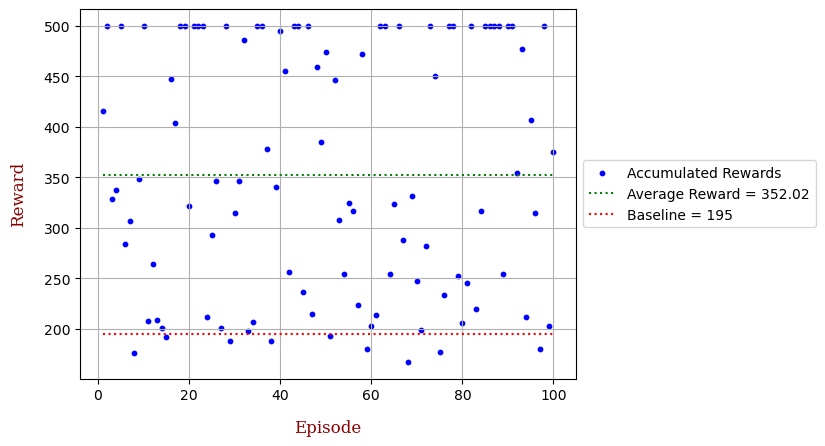

In [14]:
avg_reward = np.mean(ys)

FONTDICT = {
    "family": "serif", 
    "color" : "darkred", 
    "weight": "normal", 
    "size"  : 12,
}

plt.scatter(xs, ys, color="blue", s=10, label="Accumulated Rewards")
plt.hlines(avg_reward, 1, len(xs), linestyles="dotted", color="green", label=f"Average Reward = {avg_reward:.2f}")
plt.hlines(195, 1, len(xs), linestyles="dotted", color="red", label="Baseline = 195")
plt.xlabel("Episode", fontdict=FONTDICT, labelpad=12)
plt.ylabel("Reward",  fontdict=FONTDICT, labelpad=12)
plt.grid()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Clearly, the agent's average reward is well beyond $195$. In this sequence of $100$ runs, for example, the average reward is $352.02$. Interestingly, the agent receives the maximum reward for a lot of episodes (indicaed by points with $y=500$).

# Task 3: Render one episode played by the agent

In [15]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    action = agent.act(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()

Here, we see that the agent finds it hard to stay in the middle of the frame, but when it approaches the frame, it tries very hard to avoid going past it. My analysis (based on multiple replays) shows that the agent has learnt well to balance the pole, but has a hard time staying within the bounds of the frame.

# References

**[1]** Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. A. (2013). Playing Atari with Deep Reinforcement Learning. CoRR, abs/1312.5602. Retrieved from http://arxiv.org/abs/1312.5602.

**[2]** Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., van Kerkwijk, M. H., Brett, M., Haldane, A., Fernández del Río, J., Wiebe, M., Peterson, P., Gérard-Marchant, P., Sheppard, K., Reddy, T., Weckesser, W., Abbasi, H., Gohlke, C., & Oliphant, T. E. (2020). Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 10.1038/s41586-020-2649-2.

**[3]** Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95. DOI: 10.1109/MCSE.2007.55

**[4]** Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., Corrado, G. S., Davis, A., Dean, J., Devin, M., Ghemawat, S., Goodfellow, I., 
Harp, A., Irving, G., Isard, M., Jia, Y., Jozefowicz, R., Kaiser, L., Kudlur, M., Levenberg, J., Mane, D., Monga, R., Moore, S., Murray, D., Olah, C., Schuster, M., Shlens, J., Steiner, B., Sutskever, I., Talwar, K., Tucker, P., Vanhoucke, V., Vasudevan, V., Viegas, F., Vinyals, O., Warden, P., 
Wattenberg, M., Wicke, M., Yu, Y., & Zheng, X. (2015). TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems. Retrieved from https://www.tensorflow.org/.

**[5]** Brockman, G., Cheung, V., Pettersson, L., Schneider, J., Schulman, J., Tang, J., & Zaremba, W. (2016). OpenAI Gym. CoRR, abs/1606.01540. Retrieved from http://arxiv.org/abs/1606.01540.